# 第二讲：复杂网络的统计特性

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
# 'serif', 'sans-serif', 'monospace', 'fantasy', 'cursive'
cnFont = {'fontname':'Songti SC', 'color':'darkred', 'weight':'bold', 'size': 30}
cnFontName = {'fontname':'Songti SC'}
plt.rcParams['figure.dpi'] = 400
import seaborn as sns
import scienceplots
import numpy as np
import scipy
import pandas as pd
from pandas import Series,DataFrame
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

import networkx as nx
import igraph as ig

## 常见的度分布：泊松分布与幂律分布

### 泊松分布：以ER随机网络为例

In [2]:
n = 10000
p = 0.001
ER = nx.erdos_renyi_graph(n, p)
# 获取平均度
d = dict(nx.degree(ER))
print("平均度为：", sum(d.values())/len(ER.nodes))

平均度为： 10.041


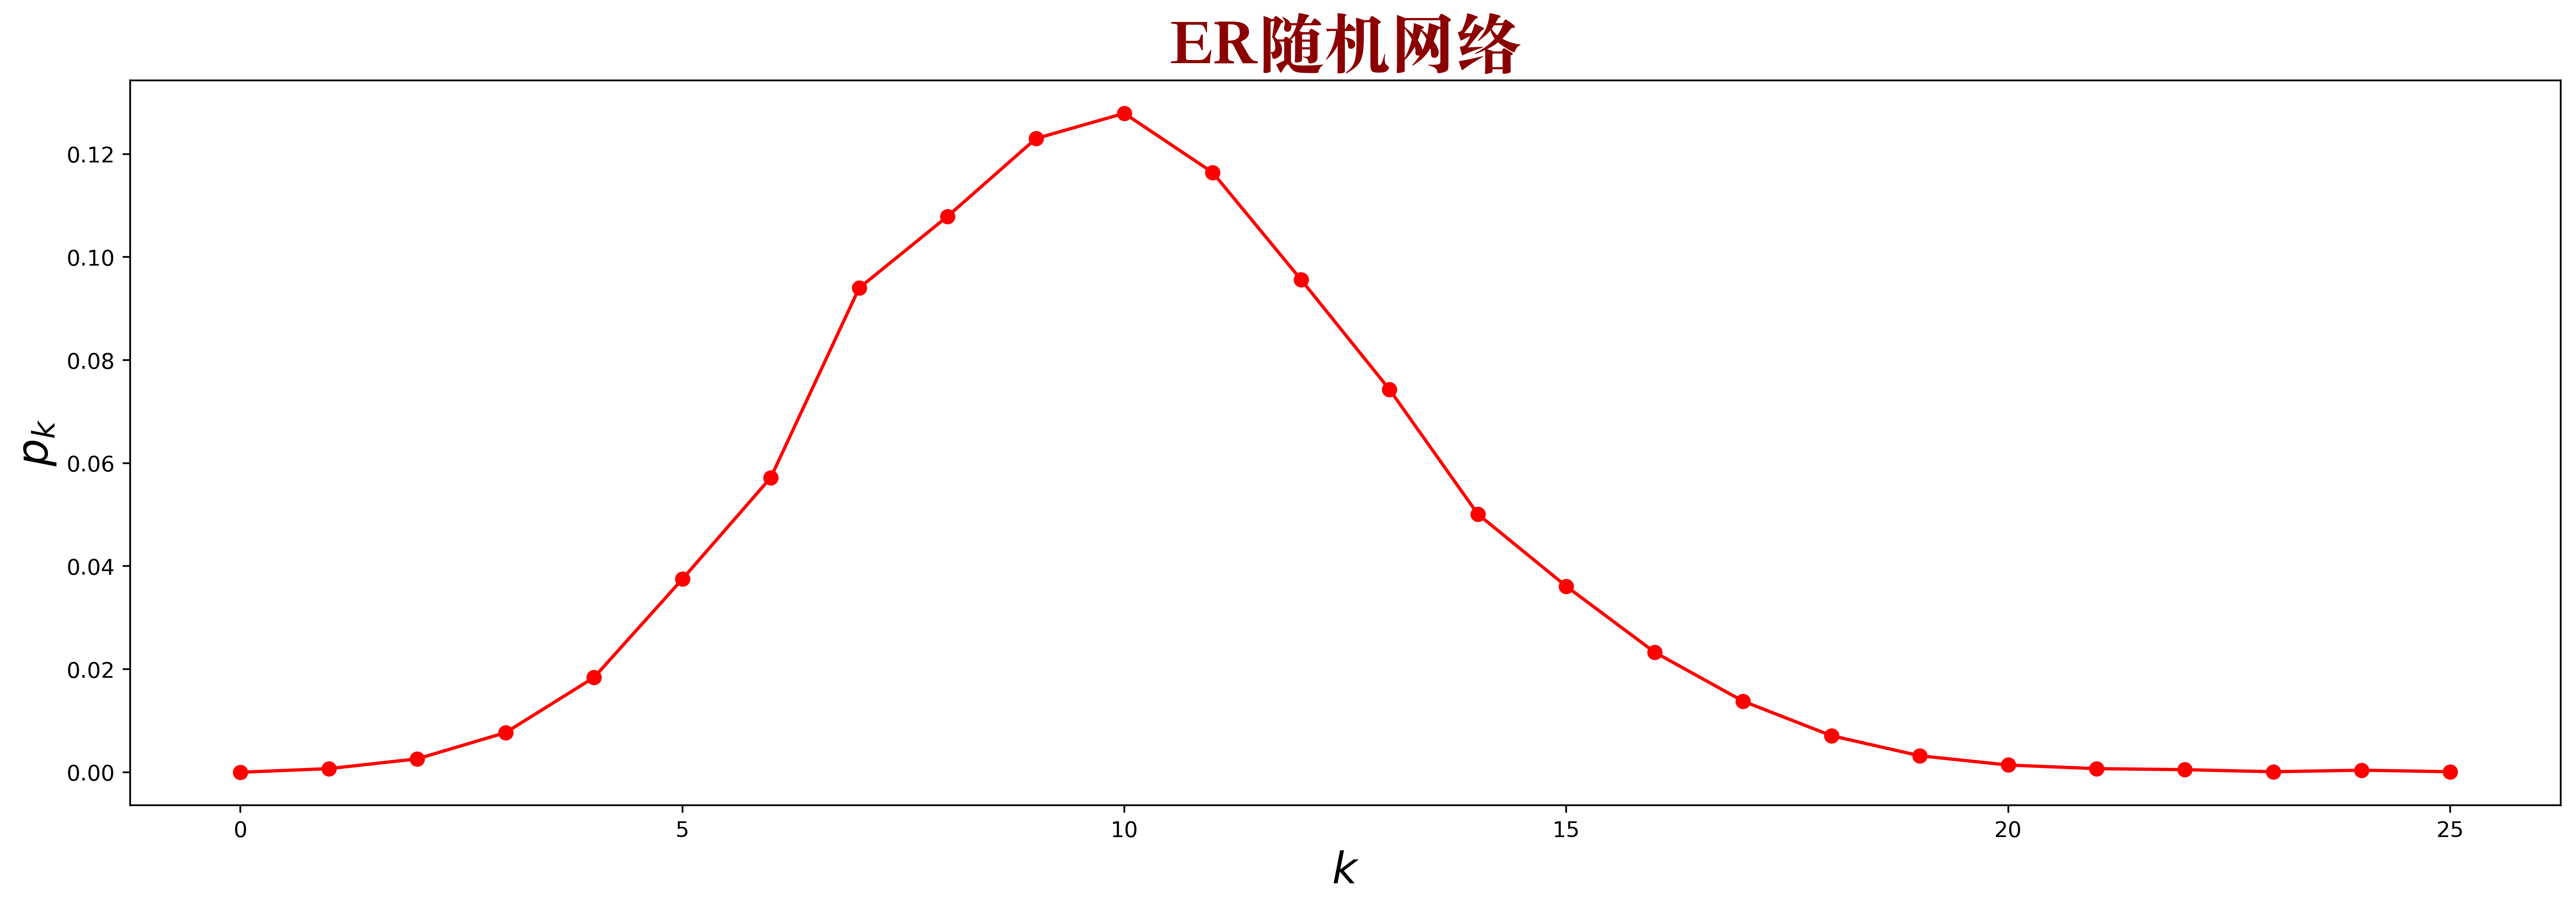

In [3]:
# 获取所有可能的度值对应的概率
x = list(range(max(d.values())+1))
y = [i/n for i in nx.degree_histogram(ER)]
# 绘制度分布
fig = plt.figure(figsize=(20,6))
plt.plot(x, y, 'ro-')
plt.xlabel("$k$", fontdict={'size': 20})
plt.ylabel("$p_k$", fontdict={'size': 20})
plt.title("ER随机网络", fontdict=cnFont)
plt.show()

### 幂律分布：以BA无标度网络为例

In [4]:
m = 3
BA = nx.barabasi_albert_graph(n, m)
# 获取平均度
d = dict(nx.degree(BA))
print("平均度为：", sum(d.values())/len(BA.nodes))

平均度为： 5.9982


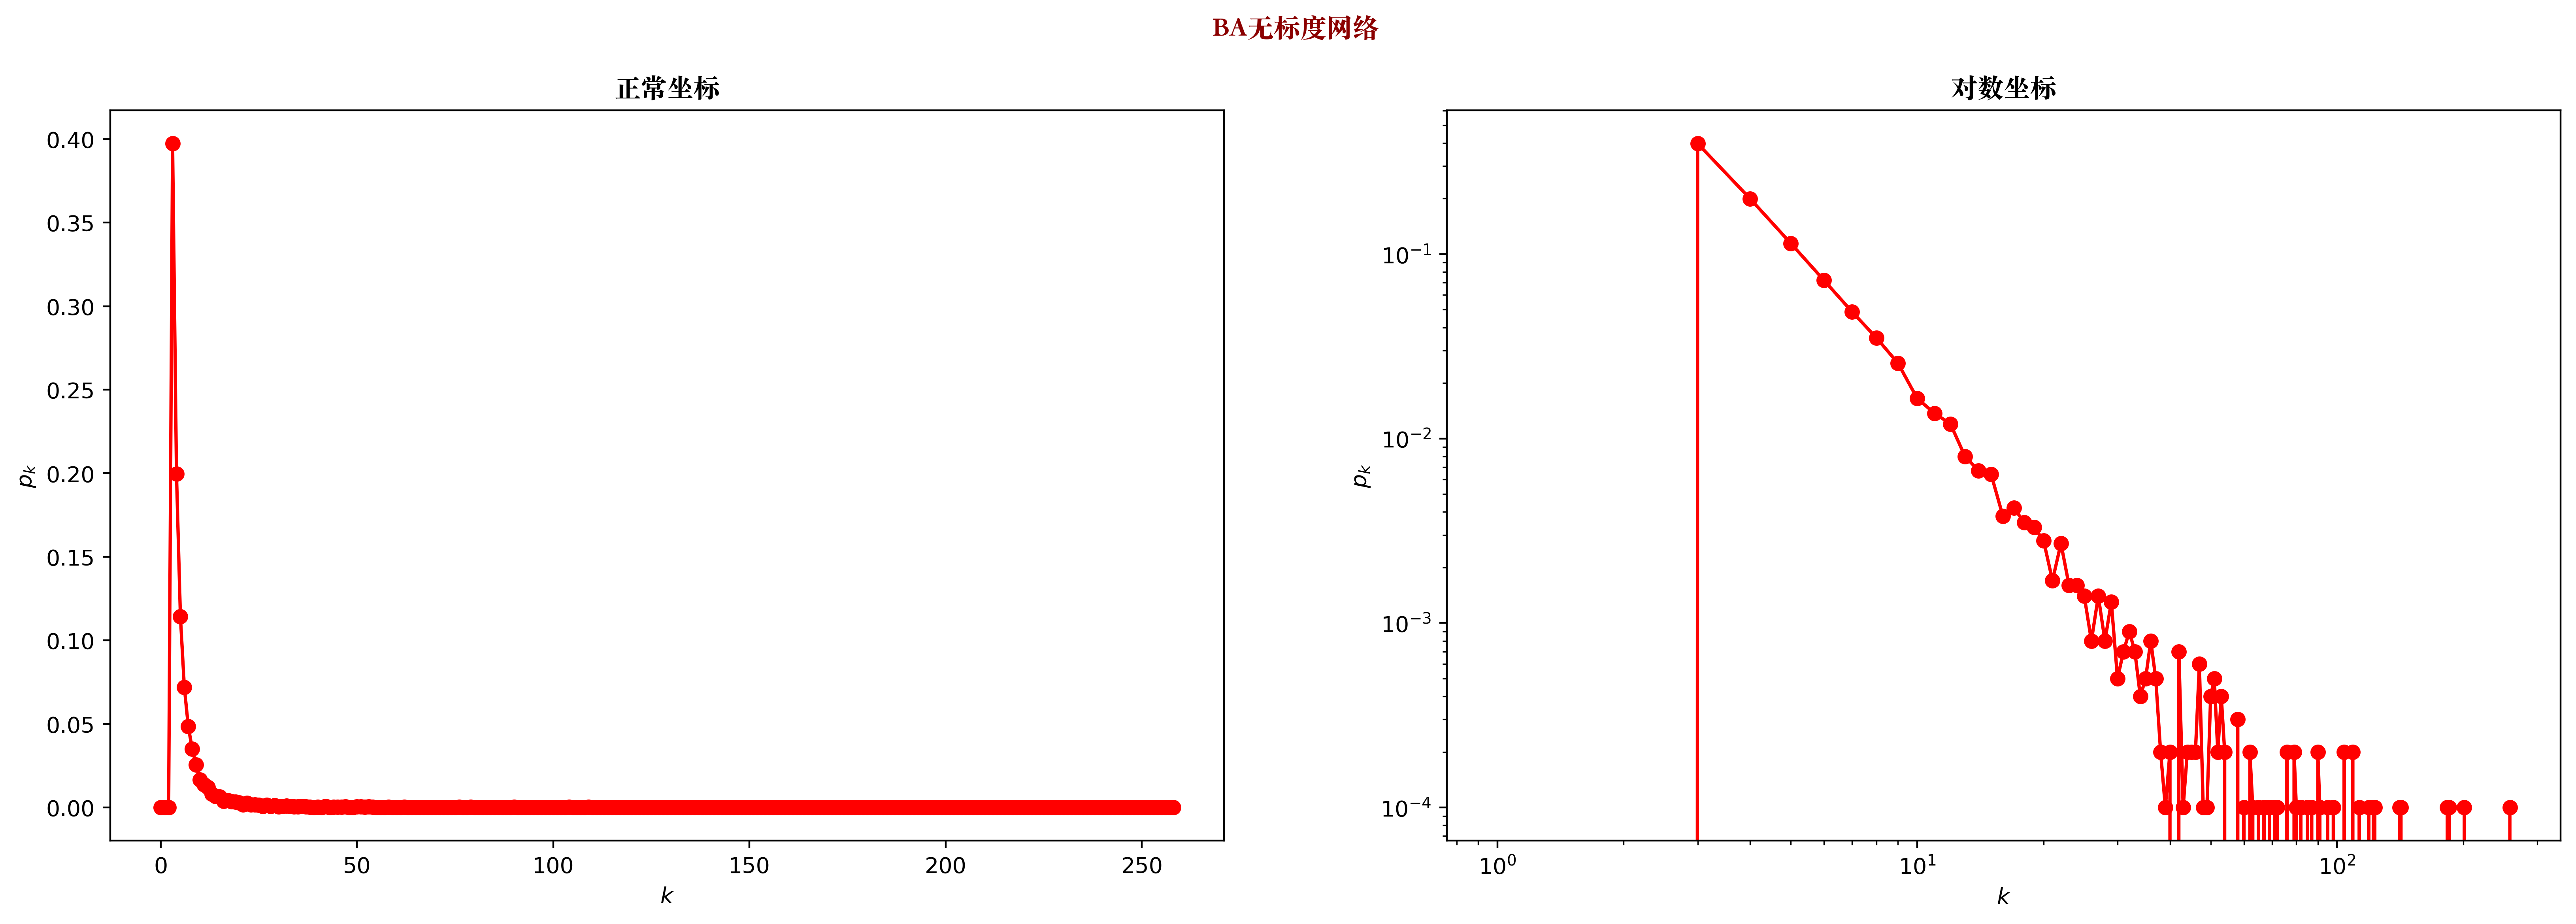

In [5]:
# 获取所有可能的度值对应的概率
x = list(range(max(d.values())+1))
y = [i/n for i in nx.degree_histogram(BA)]
# 绘制度分布
fig, axes = plt.subplots(1,2,figsize=(20,6))
fig.suptitle("BA无标度网络", fontdict=cnFont)


axes[0].plot(x, y, 'ro-')
axes[0].set_xlabel("$k$")
axes[0].set_ylabel("$p_k$")
axes[0].set_title("正常坐标", fontdict=cnFontName)


# 在双对数坐标轴下显示
axes[1].plot(x, y, 'ro-')
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel("$k$")
axes[1].set_ylabel("$p_k$")
axes[1].set_title("对数坐标", fontdict=cnFontName)


plt.show()

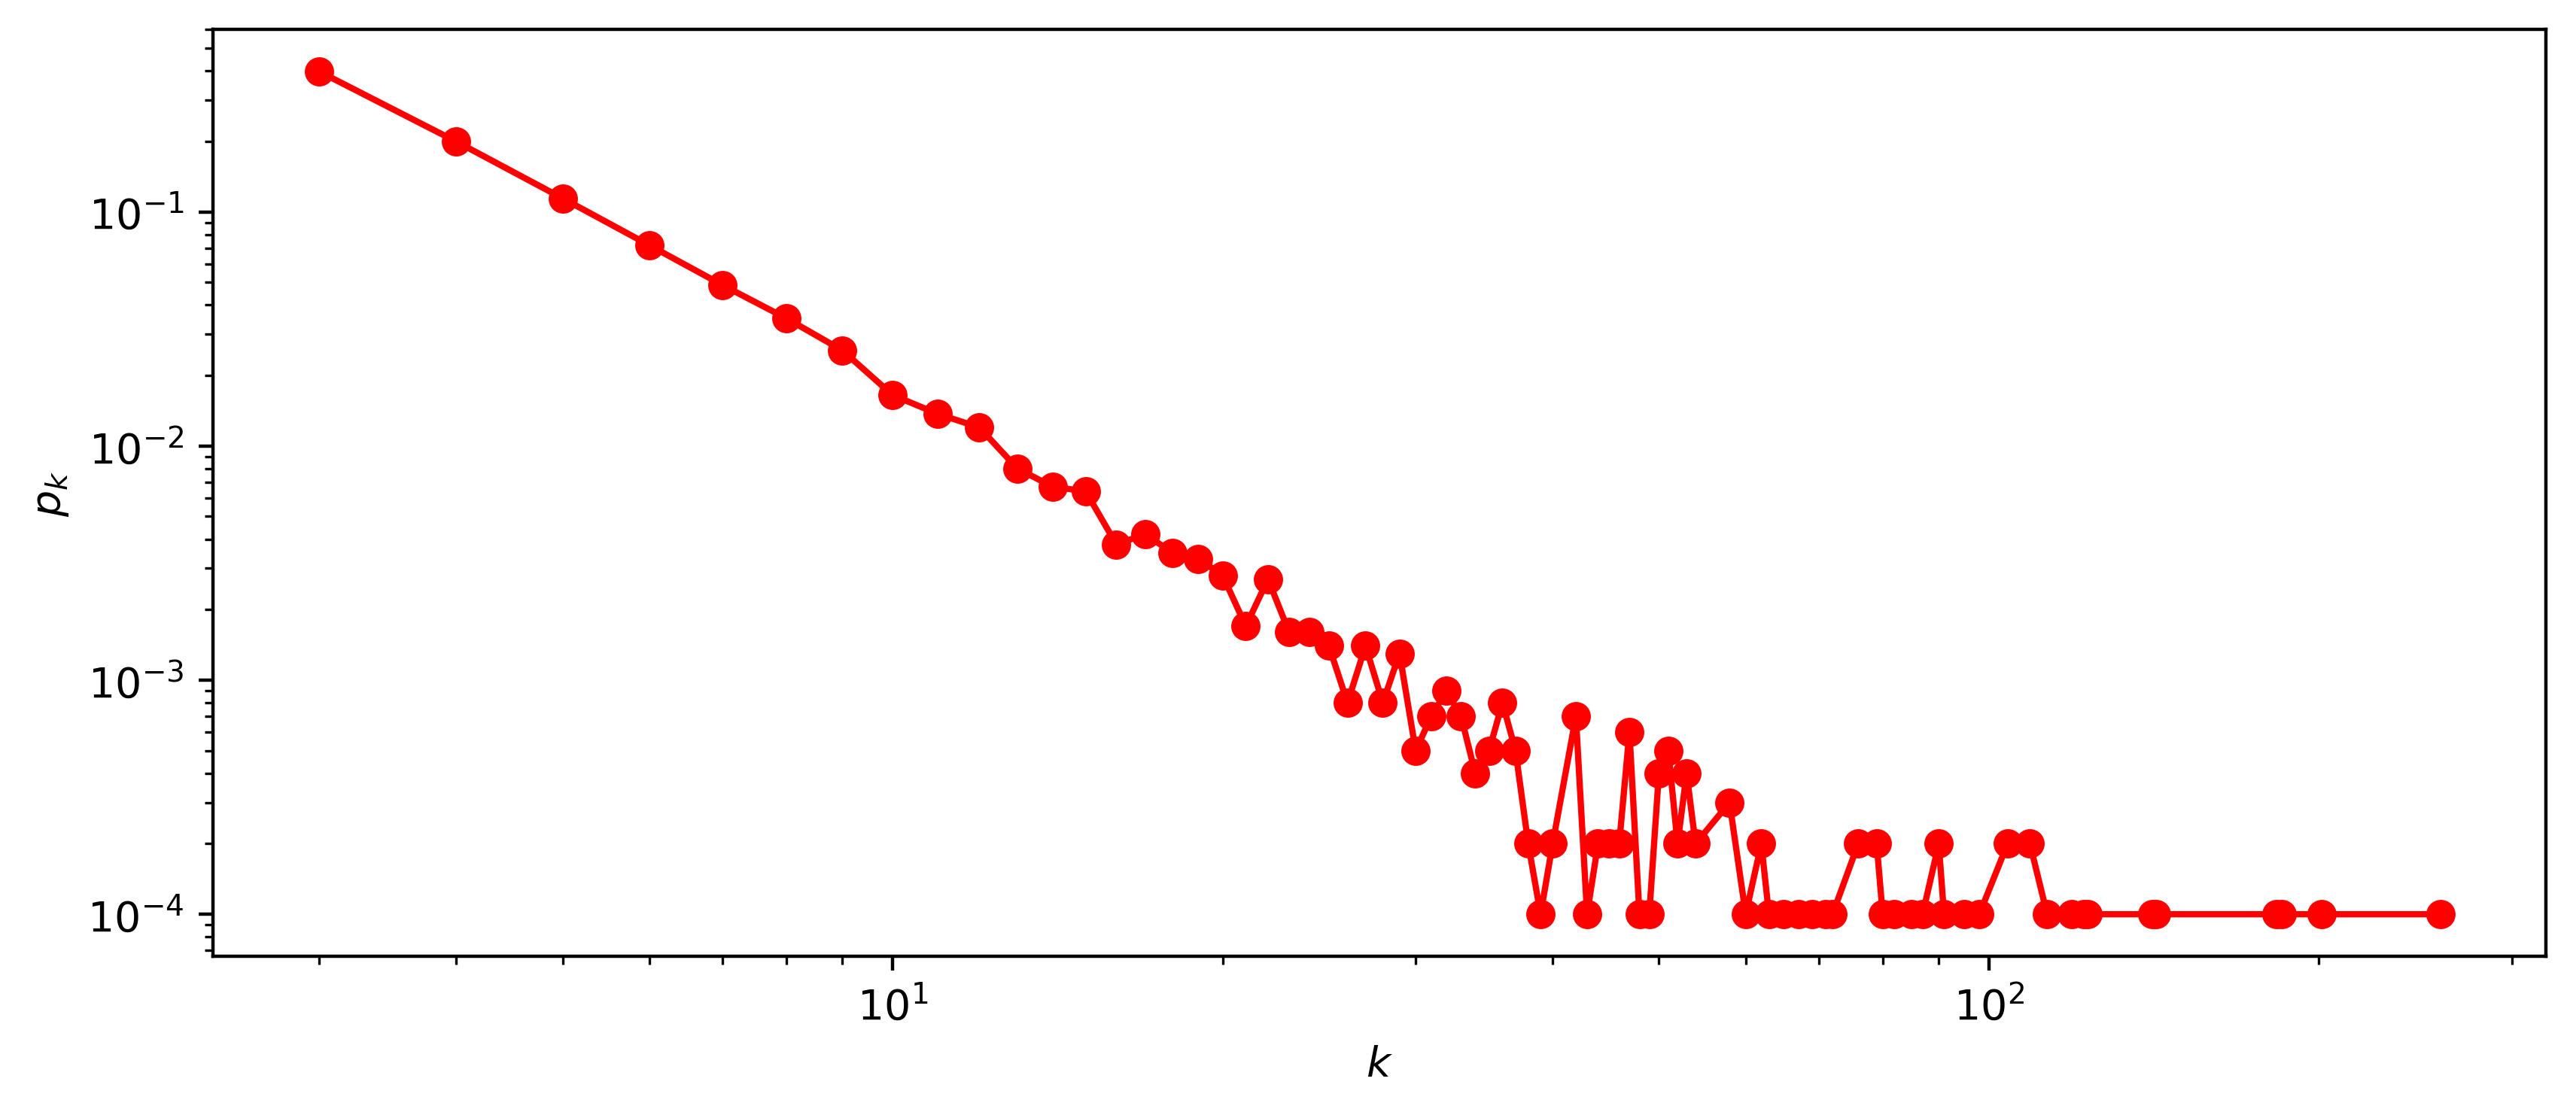

In [6]:
x_new = [ x[i] for i in range(len(x)) if y[i] != 0 ]
y_new = [ y[i] for i in range(len(y)) if y[i] != 0 ]
fig = plt.figure(figsize=(10,4))
plt.plot(x_new, y_new, 'ro-')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$k$")
plt.ylabel("$p_k$")
plt.show()

## 网络的直径、效率和平均最短距离

### 直径

In [7]:
G1 = nx.barabasi_albert_graph(1000, 3)
print("网络的直径为：", nx.diameter(G1))

网络的直径为： 6


### 效率

In [8]:
# 指定节点对i和j之间的效率：前提是这两个节点之家要有路径，即从i到j是可达的
print(nx.efficiency(G1, 1, 5))
print(nx.shortest_path_length(G1, 1, 5))
# 局部效率
print(nx.local_efficiency(G1))
# 全局效率：直接调用下列函数的前提是网络G1要是连通的
print(nx.global_efficiency(G1))

1.0
1
0.03165780687627327
0.3041319652994003


### 平均最短距离

In [9]:
# 求整个网络的平均距离：直接调用下列函数的前提是网络G1要是连通的
print(nx.average_shortest_path_length(G1))

3.476834834834835


### 集聚系数

In [10]:
# print(nx.clustering(G1))
# 平均集聚系数
print(nx.average_clustering(G1))
# 全局集聚系数
print(nx.transitivity(G1))

0.028884863824684026
0.018399734226061178


### 度度相关性

#### 1. 基于最近邻平均度值的度-度相关性

In [11]:
# 加载三个真实数据集
# 1. 科学合作网络
df1 = pd.read_csv("data/citation.edgelist.csv")
G1 = nx.from_pandas_edgelist(df1, 'source', 'target', create_using = nx.Graph())
# 2. 电网
df2 = pd.read_csv("data/power.edgelist.csv")
G2 = nx.from_pandas_edgelist(df2, 'source', 'target', create_using = nx.Graph())
# 3. 代谢网络
df3 = pd.read_csv("data/celegans_metabolic.edgelist.csv")
G3 = nx.from_pandas_edgelist(df3, 'source', 'target', create_using = nx.Graph())

In [12]:
def average_nearest_neighbor_degree_with_array(G):
    # A = nx.adjacency_matrix(G).todense()
    A = nx.to_numpy_array(G, dtype=np.int64)
    N = len(G.nodes())
    k_array = np.array([G.degree(node) for node in G.nodes()])
    # k_array = A.sum(axis=1)
    k_set = sorted(set(k_array)) # 获取所有可能的度值

    k_nn_i = A @ k_array / k_array
    NP = np.array([ nx.degree_histogram(G)[k] for k in k_set ])

    isK = np.zeros((N, len(k_set)))
    for ind in range(len(k_set)):
        x_index = k_array == k_set[ind]
        isK[x_index, ind] = 1

    Knn = k_nn_i @ isK / NP
    return k_set, Knn

In [13]:
# 定义求最近邻平均度的函数
def average_nearest_neighbor_degree(G):
    k = set([G.degree(i) for i in G.nodes()]) # 获取所有可能的度值
    sorted_k = sorted(k)
    
    k_nn_k = []
    for ki in sorted_k:
        if ki == 0:
            k_nn_k.append(0.0)
        else:
            c = 0
            k_nn_i = 0
            for i in G.nodes():
                if G.degree(i) == ki:  
                    k_nn_i += sum([G.degree(j) for j in list(nx.all_neighbors(G,i))])/ki
                    c += 1
            k_nn_k.append(k_nn_i/c)
    return sorted_k, k_nn_k

In [14]:
k_set1, Knn1 = average_nearest_neighbor_degree_with_array(G1)
sorted_k1, k_nn_k1 = average_nearest_neighbor_degree(G1)
k_set2, Knn2 = average_nearest_neighbor_degree_with_array(G2)
sorted_k2, k_nn_k2 = average_nearest_neighbor_degree(G2)
k_set3, Knn3 = average_nearest_neighbor_degree_with_array(G3)
sorted_k3, k_nn_k3 = average_nearest_neighbor_degree(G3)

: 

: 

<Figure size 4000x2400 with 0 Axes>

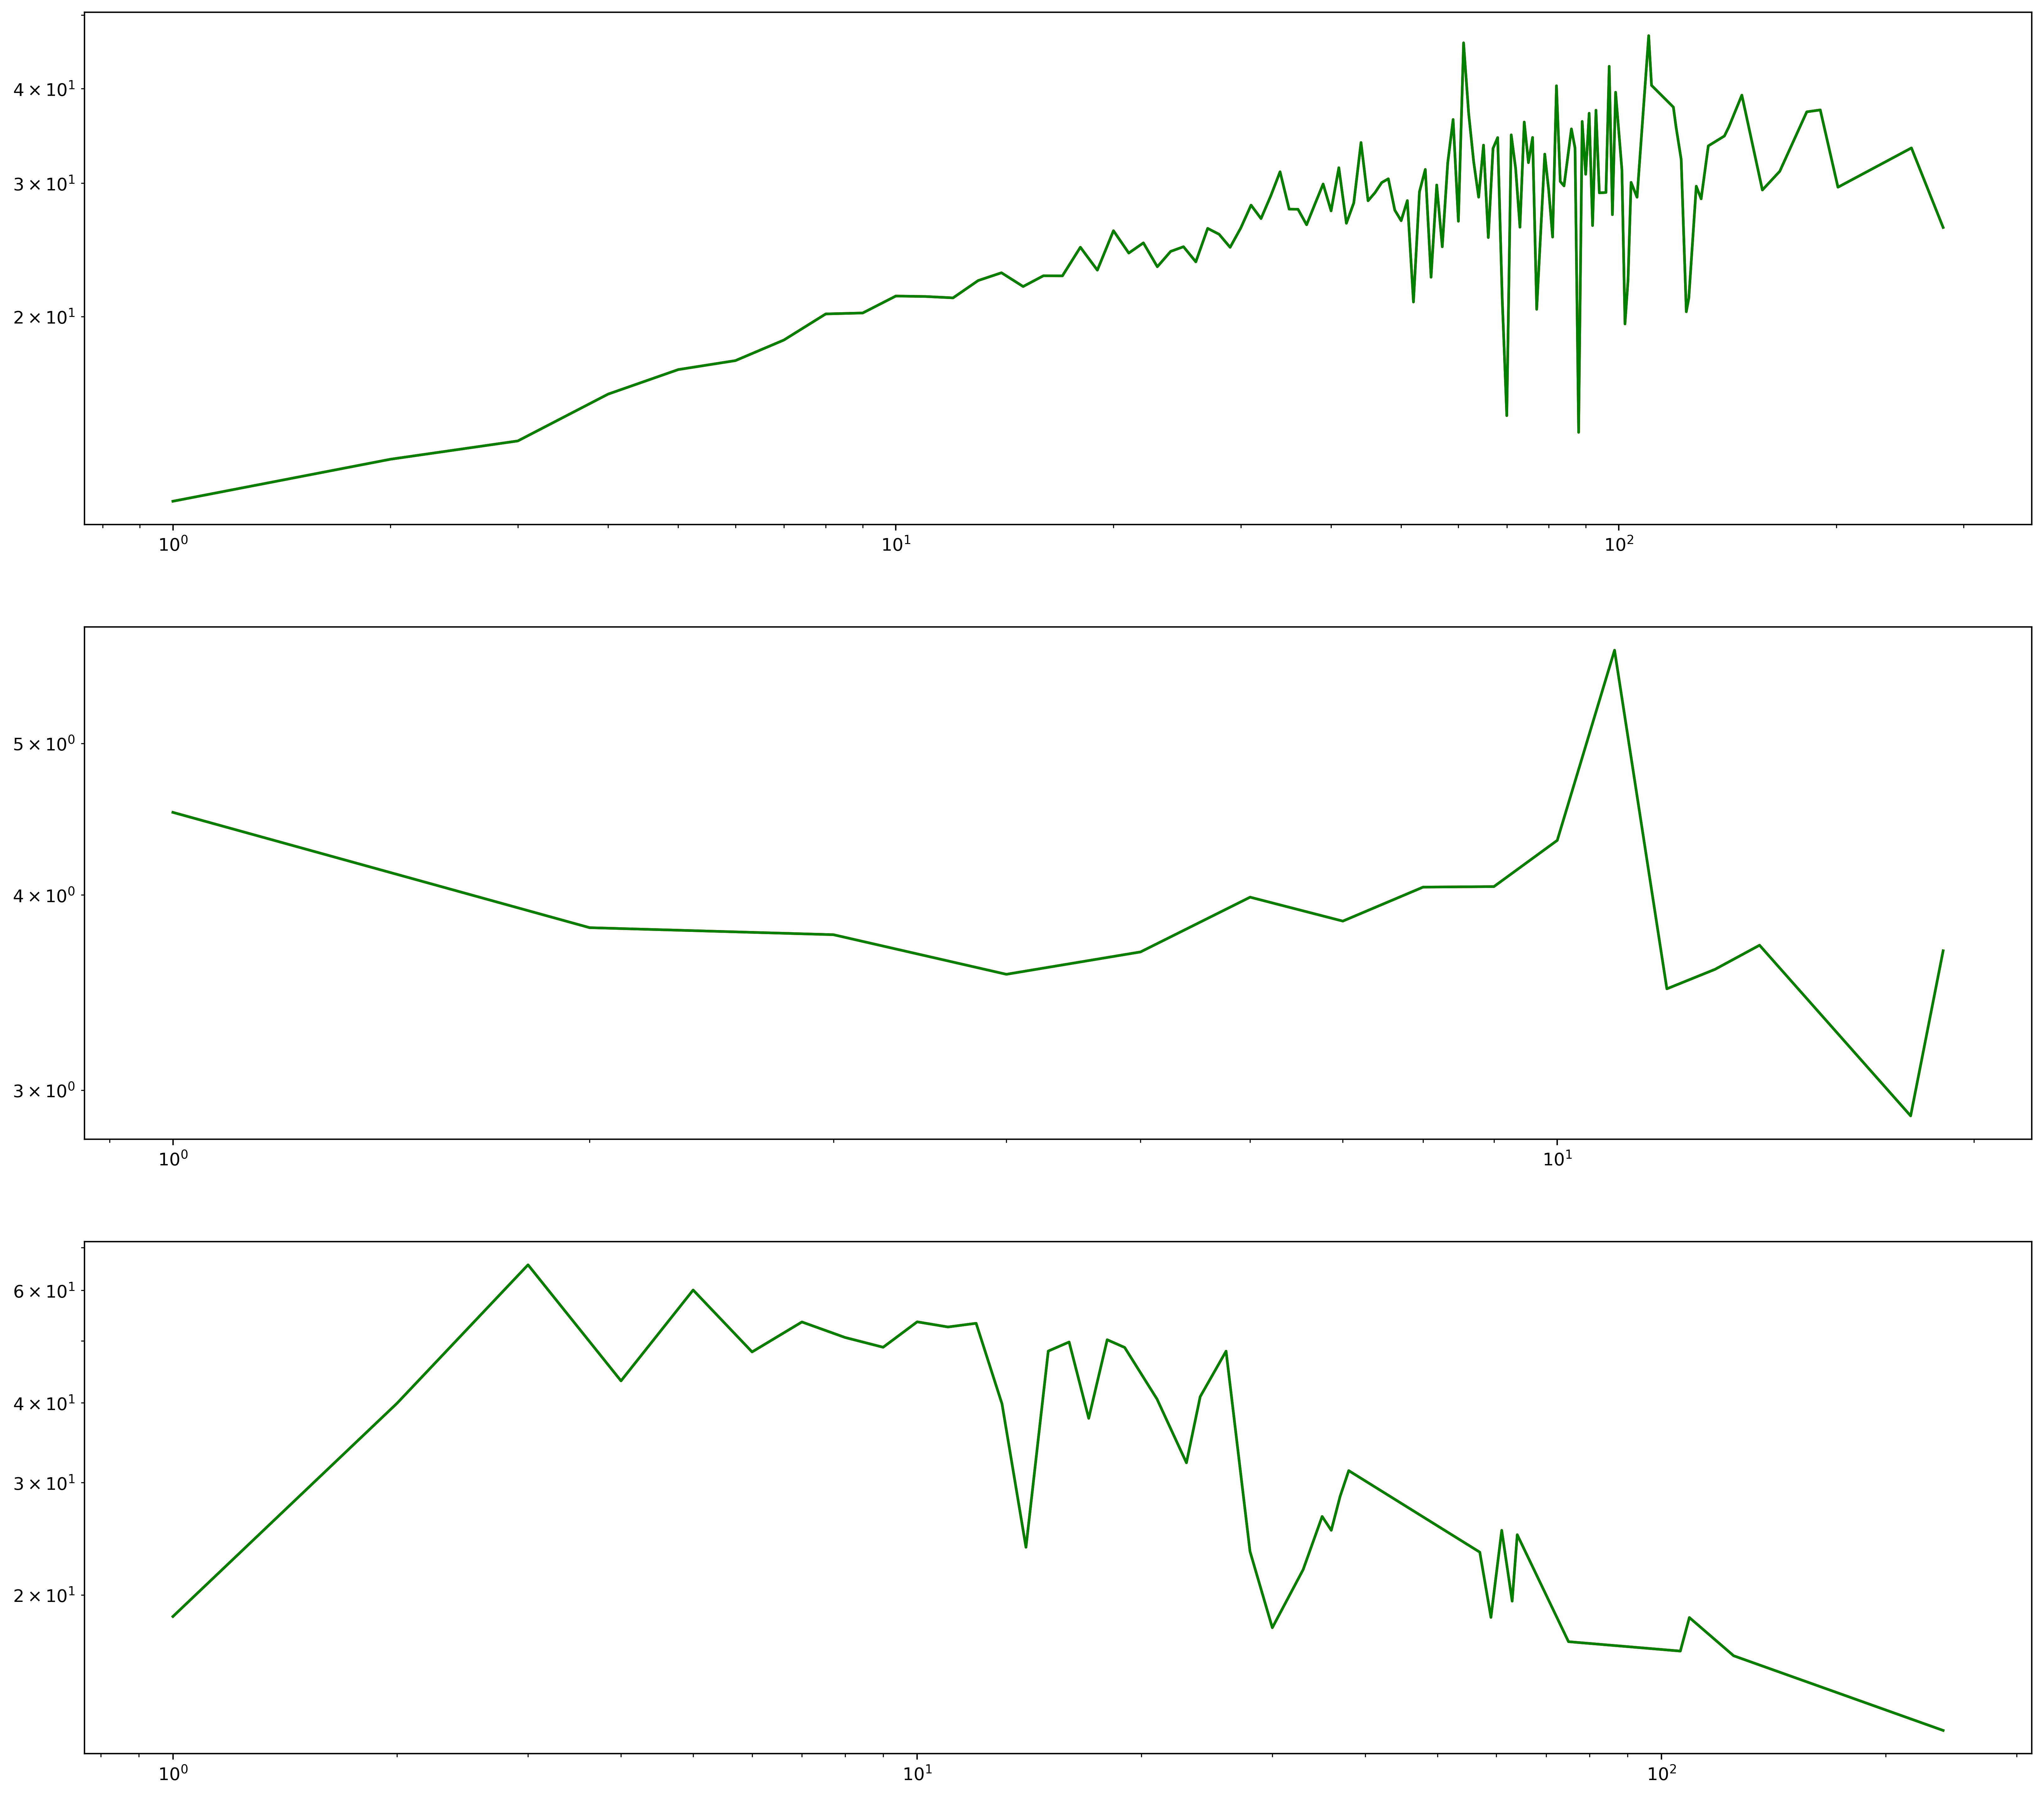

In [ ]:
fig = plt.figure(figsize=(10,6))

fig, axes = plt.subplots(3,1,figsize=(20,18))

axes[0].plot(k_set1, Knn1, color='red')
axes[0].plot(sorted_k1, k_nn_k1, color='green')
axes[0].set_xscale("log")
axes[0].set_yscale("log")

axes[1].plot(k_set2, Knn2, color='red')
axes[1].plot(sorted_k2, k_nn_k2, color='green')
axes[1].set_xscale("log")
axes[1].set_yscale("log")

axes[2].plot(k_set3, Knn3, color='red')
axes[2].plot(sorted_k3, k_nn_k3, color='green')
axes[2].set_xscale("log")
axes[2].set_yscale("log")

plt.show()

### 2. 基于Pearson相关系数的度-度相关性

In [ ]:
r1 = nx.degree_assortativity_coefficient(G1)
r2 = nx.degree_assortativity_coefficient(G2)
r3 = nx.degree_assortativity_coefficient(G3)
print(r1)
print(r2)
print(r3)

0.13506886900042142
0.0034569877442048825
-0.219662309363656


In [ ]:
r1 = nx.degree_pearson_correlation_coefficient(G1)
r2 = nx.degree_pearson_correlation_coefficient(G2)
r3 = nx.degree_pearson_correlation_coefficient(G3)
print(r1)
print(r2)
print(r3)

0.13506886900042137
0.0034569877442048244
-0.21966230936365608


## 介数和核度

### 节点介数

In [ ]:
BA = nx.barabasi_albert_graph(20, 2)
bc = nx.betweenness_centrality(BA)
print(bc)
# 获取介数最大的节点标签
max_id = max(bc, key=bc.get)
print(max_id)
# 绘制网络
# nx.draw(BA, node_size=500, with_labels=True)

{0: 0.32076023391812863, 1: 0.17417153996101362, 2: 0.29814814814814816, 3: 0.024366471734892783, 4: 0.04035087719298246, 5: 0.09259259259259257, 6: 0.004873294346978557, 7: 0.05847953216374269, 8: 0.006042884990253411, 9: 0.0, 10: 0.0024366471734892786, 11: 0.0060428849902534115, 12: 0.0604288499025341, 13: 0.007797270955165692, 14: 0.07992202729044834, 15: 0.005847953216374269, 16: 0.0024366471734892786, 17: 0.0, 18: 0.0034113060428849896, 19: 0.004873294346978557}
0


### 边介数

In [ ]:
ebc = nx.edge_betweenness_centrality(BA)
print(ebc)

{(0, 1): 0.05614035087719296, (0, 2): 0.06991228070175437, (0, 3): 0.06499999999999999, (0, 4): 0.039649122807017545, (0, 5): 0.08377192982456139, (0, 9): 0.06271929824561404, (0, 11): 0.0813157894736842, (0, 12): 0.09078947368421054, (0, 17): 0.05263157894736842, (0, 18): 0.07543859649122807, (1, 3): 0.04622807017543858, (1, 4): 0.0519298245614035, (1, 6): 0.06491228070175438, (1, 9): 0.03728070175438596, (1, 10): 0.046052631578947366, (1, 14): 0.06491228070175438, (1, 16): 0.046052631578947366, (2, 5): 0.075, (2, 7): 0.08543859649122805, (2, 8): 0.07824561403508772, (2, 10): 0.058333333333333334, (2, 13): 0.07894736842105263, (2, 14): 0.0850877192982456, (2, 16): 0.05833333333333333, (2, 17): 0.04736842105263158, (3, 8): 0.03263157894736842, (4, 7): 0.04552631578947368, (4, 12): 0.03552631578947368, (5, 6): 0.04385964912280701, (5, 19): 0.06403508771929824, (7, 11): 0.02956140350877193, (7, 19): 0.04473684210526316, (12, 13): 0.03508771929824561, (12, 15): 0.04736842105263158, (14, 1

### 核度

In [ ]:
ks = nx.core_number(BA)
print(ks)

{0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 2}


In [ ]:
# 换一个网络试试
kcg = nx.karate_club_graph()
ks = nx.core_number(kcg)
print(ks)
# 获取核度最大的节点标签
max_id = max(ks, key=ks.get)
print(max_id)
# nx.draw(BA, node_size=500, with_labels=True)

{0: 4, 1: 4, 2: 4, 3: 4, 4: 3, 5: 3, 6: 3, 7: 4, 8: 4, 9: 2, 10: 3, 11: 1, 12: 2, 13: 4, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2, 19: 3, 20: 2, 21: 2, 22: 2, 23: 3, 24: 3, 25: 3, 26: 2, 27: 3, 28: 3, 29: 3, 30: 4, 31: 3, 32: 4, 33: 4}
0


In [ ]:
# 获得度大于等于k的最大子图
k_subgraph = nx.k_core(kcg, k=2)
# nx.draw(k_subgraph, node_size=500, with_labels=True)

### 网络密度

In [ ]:
print(nx.density(kcg))

0.13903743315508021


## 几种常用的中心性指标

In [ ]:
# 分别生成ER和BA无标度网络，节点数设定为N=100
GER = nx.erdos_renyi_graph(100,0.08)
GBA = nx.barabasi_albert_graph(100,4)
# 度中心性
dc1 = nx.degree_centrality(GER) 
dc2 = nx.degree_centrality(GBA) 
# 介数中心性
bc1 = nx.betweenness_centrality(GER)
bc2 = nx.betweenness_centrality(GBA)
# 接近度中心性
cc1 = nx.closeness_centrality(GER)
cc2 = nx.closeness_centrality(GBA)
# 特征向量中心性
ec1 = nx.eigenvector_centrality(GER)
ec2 = nx.eigenvector_centrality(GBA)

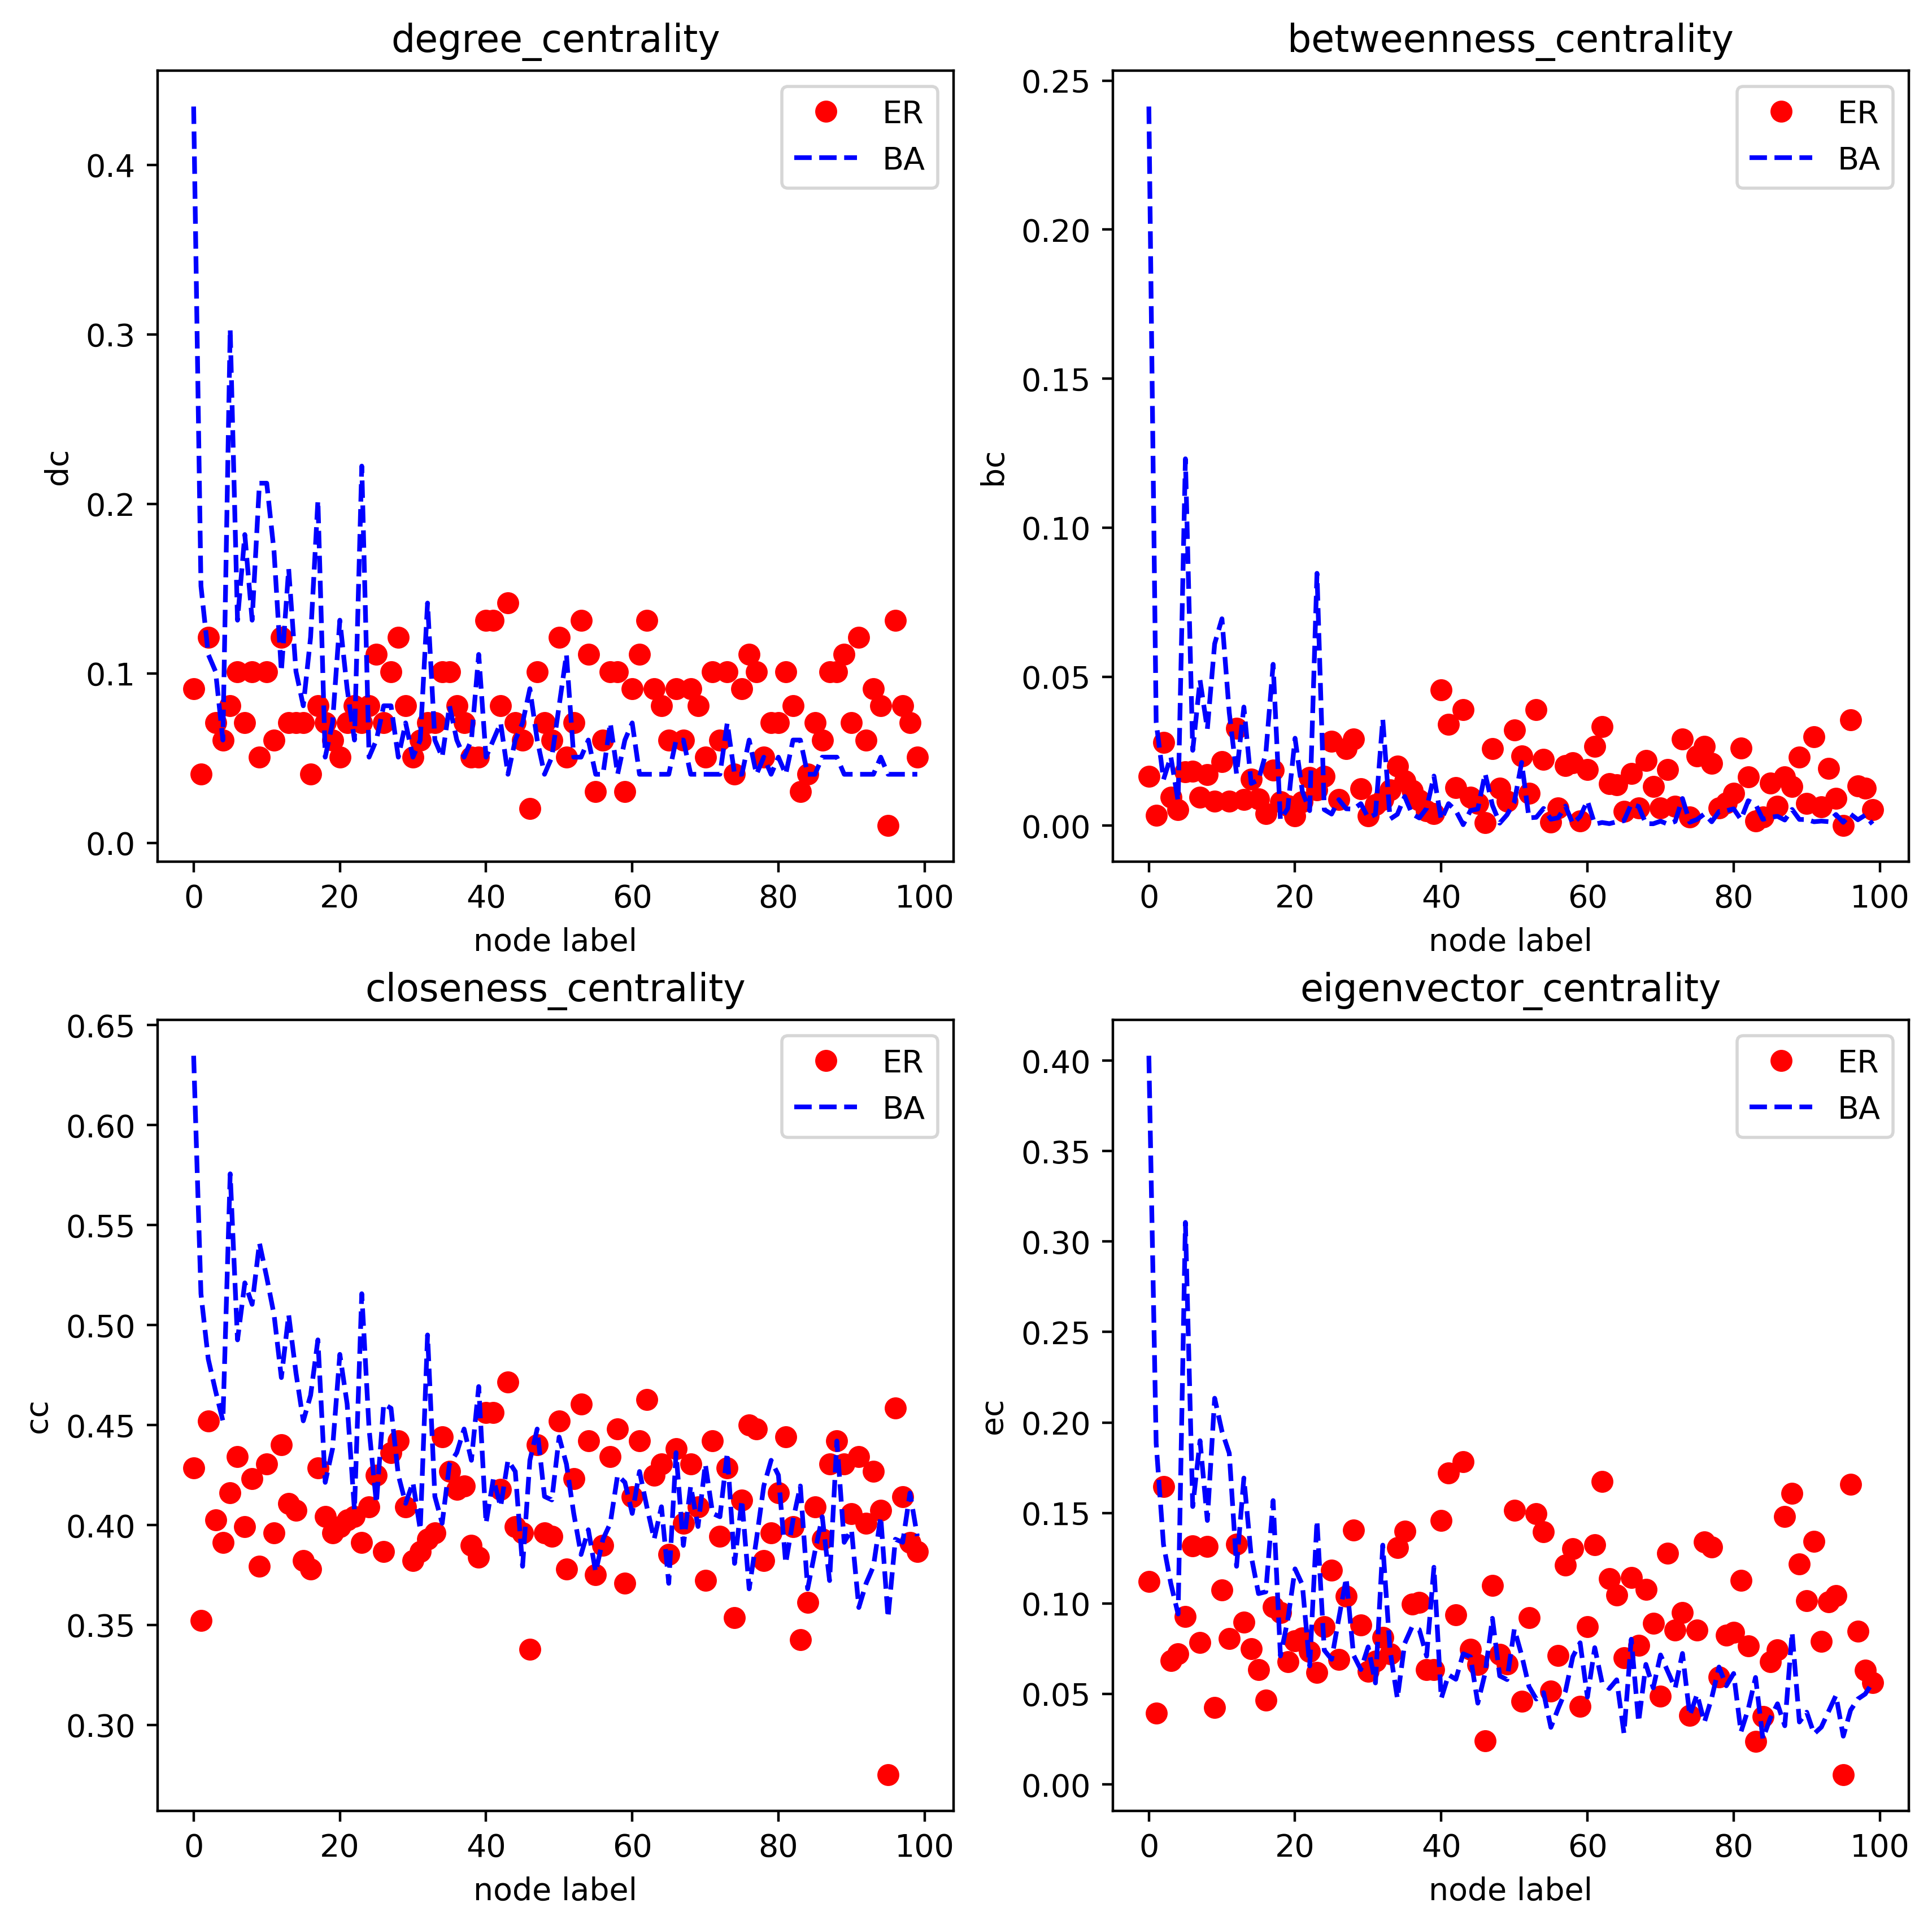

In [ ]:
# 绘图比较
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(dc1.keys(), dc1.values(), 'ro', label='ER')
plt.plot(dc2.keys(), dc2.values(), 'b--', label='BA')
plt.legend(loc=0)
plt.xlabel("node label")
plt.ylabel("dc")
plt.title("degree_centrality")

plt.subplot(222)
plt.plot(bc1.keys(), bc1.values(), 'ro', label='ER')
plt.plot(bc2.keys(), bc2.values(), 'b--', label='BA')
plt.legend(loc=0)
plt.xlabel("node label")
plt.ylabel("bc")
plt.title("betweenness_centrality")

plt.subplot(223)
plt.plot(cc1.keys(), cc1.values(), 'ro', label='ER')
plt.plot(cc2.keys(), cc2.values(), 'b--', label='BA')
plt.legend(loc=0)
plt.xlabel("node label")
plt.ylabel("cc")
plt.title("closeness_centrality")

plt.subplot(224)
plt.plot(ec1.keys(), ec1.values(), 'ro', label='ER')
plt.plot(ec2.keys(), ec2.values(), 'b--', label='BA')
plt.legend(loc=0)
plt.xlabel("node label")
plt.ylabel("ec")
plt.title("eigenvector_centrality")

plt.show()

## 有向网络与加权网络的静态特征

### 有向网络

In [ ]:
# 创建一个空的有向网络
DG = nx.DiGraph()
DG.add_nodes_from([1,2,3,4,5,6])
DG.add_edges_from([(1,2),(1,3),(2,4),(3,5),(4,6),(5,2),(5,4),(5,3),(3,6)])
# nx.draw(DG,node_size=500,with_labels=True)

In [ ]:
# 获取各个节点的入度、出度和总度
print(DG.in_degree)
print(DG.out_degree)
print(DG.degree)

[(1, 0), (2, 2), (3, 2), (4, 2), (5, 1), (6, 2)]
[(1, 2), (2, 1), (3, 2), (4, 1), (5, 3), (6, 0)]
[(1, 2), (2, 3), (3, 4), (4, 3), (5, 4), (6, 2)]


### 加权网络

In [ ]:
# 创建一个无向加权网络
WG = nx.Graph()
WG.add_nodes_from([1,2,3,4,5,6])
WG.add_weighted_edges_from([(1,2,3),(1,3,1),(2,4,4),(2,5,1.5),(3,5,2),(3,6,3.5),(4,5,2.5),(4,6,0.5)])
w = [WG[e[0]][e[1]]['weight'] for e in WG.edges()]
# nx.draw(WG,node_size=500,width=w,with_labels=True)

In [ ]:
# 获取网络节点的加权度（即点权）
nx.degree(WG, weight='weight')
# 获取每条边的权重
for e in WG.edges():
    print(WG[e[0]][e[1]]['weight'])

3
1
4
1.5
2
3.5
2.5
0.5
